In [14]:
import requests, json, numpy, datetime
import pywren
import boto3
import numpy as np
from pyproj import Proj
import warnings
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
warnings.filterwarnings('ignore')

In [3]:
# Leaving this here if needed: https://medium.com/@jenoyamma/how-to-install-python-packages-for-aws-lambda-layer-74e193c76a91
BUCKET = 'mapping-disaster-risk'

GEOJSONS = ['train-borde_rural.geojson', 'train-borde_soacha.geojson',
            'train-castries.geojson', 'train-dennery.geojson',
            'train-gros_islet.geojson', 'train-mixco_1_and_ebenezer.geojson',
            'train-mixco_3.geojson']

TIFS = ['borde_rural_ortho-cog.tif', 'borde_soacha_ortho-cog.tif',
        'castries_ortho-cog.tif', 'dennery_ortho-cog.tif',
        'gros_islet_ortho-cog.tif', 'mixco_1_and_ebenezer_ortho-cog.tif',
        'mixco_3_ortho-cog.tif']

tif_list = [{'tif':"borde_rural_ortho-cog.tif",
    'crs': 'epsg:32618',
    'geojson': 'train-borde_rural.geojson',
    'output': 'colombia_rural_zonal.csv'},
    {'tif':"borde_soacha_ortho-cog.tif",
    'crs': 'epsg:32618',
    'geojson':'train-borde_soacha.geojson',
    'output': 'colombia_soacha_zonal.csv'},
    {'tif':"mixco_1_and_ebenezer_ortho-cog.tif",
    'crs': 'epsg:32616',
    'geojson': 'train-mixco_1_and_ebenezer.geojson',
    'output': 'guatemala_mixco_1_zonal.csv'},
    {'tif':"mixco_3_ortho-cog.tif",
    'crs': 'epsg:32616',
    'geojson': 'train-mixco_3.geojson',
    'output': 'guatemala_mixco_3_zonal.csv'},
    {'tif':"castries_ortho-cog.tif",
    'crs': 'epsg:32620',
    'geojson': 'train-castries.geojson',
    'output': 'stlucia_castries_zonal.csv'},
    {'tif':"dennery_ortho-cog.tif",
    'crs': 'epsg:32620',
    'geojson': 'train-dennery.geojson',
    'output': 'stlucia_dennery_zonal.csv'},
    {'tif':"gros_islet_ortho-cog.tif",
    'crs': 'epsg:32620',
    'geojson': 'train-gros_islet.geojson',
    'output': 'stlucia_gros_islet_zonal.csv'}]

In [ ]:
# Note that all geojsonn names are the object names as well, so to access an object call:
# https://mapping-disaster-risk.s3.amazonaws.com/train-borde_rural.geojson

In [4]:
# Step 1: Get all geojsons and create new footprint dictionaries
def get_geojsons(dictionary):
    '''
    Given a full geojson dictionary, extracts relevant information for each
    building, including type, building id, roof material, and coordinates.
    Returns a list of dictionaries, where each dictionary maps a building by
    these features.
   
    Input:
        geojson (str): name of geojson dictionary
    
    Output:
        polygons (lst): a list of dictionaries (one per building)
    '''
    geojson = dictionary['geojson']
    tif = dictionary['tif']
    crs = dictionary['crs']
    output = dictionary['output']

    try:
        s3 = boto3.client('s3', 'us-east-1')
        obj = s3.get_object(Bucket='mapping-disaster-risk', Key=geojson)
        geo_json = json.load(obj['Body'])
        polygons = []
        for feature in geo_json['features']:
            polygon = {}
            polygon['type'] = feature['geometry']
            polygon['bid'] = feature['id']
            polygon['roof_material'] = feature['properties']['roof_material']
            polygon['coordinates'] = feature['geometry']['coordinates']
            polygon['geojson'] = geojson
            polygon['tif'] = tif
            polygon['crs'] = crs
            polygon['output'] = output
            polygons.append(polygon)
    except Exception as e:
        return e

    return polygons

In [5]:
def transform_coordinates(list_polygon_list):
    '''
    Given building footprints, executes an affine transformation on each
    coordinate pair to output a new coordinate pair based on a provided
    coordinate reference system (crs) from the corresponding geotiff file.
    Serial since Proj is not natively installed on Lambda.
    
    Input:
        polygon_list (lst): one dictionary footprint per building

    Output:
        updated_polygons (lst): a list of dictionaries (one per building)
    '''
    final_lst = []
    for polygon_list in list_polygon_list:
        geojson = polygon_list[0]['geojson']
        crs = polygon_list[0]['crs']
        tif = polygon_list[0]['tif']
        transform = Proj(init=crs)

        updated_polygons = []
        for polygon in polygon_list:
            for coordinates_list in polygon['coordinates']:
                inner_coord_list = []
                for coordinate in coordinates_list:
                    transformed_coordinate = list(transform(coordinate[0],
                                                            coordinate[1]))
                    inner_coord_list.append(transformed_coordinate)        
                polygon['coordinates'] = inner_coord_list
                updated_polygons.append(polygon)
        final_lst.append(updated_polygons)

    return final_lst

In [6]:
def get_rooftop_array_after_mask(URL, polygons):
    '''
    Given a dictionary containing transformed coordinates for one roof,
    returns an array of arrays, each one providing a numeric value for each
    pixel in the image for a specific band (in this case, 4 matrices for 4
    bands).
    Eg. Values from 0-255 correspond with the color scale.
    Input:
        tiff_path (str): path to the tif file
        polygon (dict): a dictionary of features including coordinates for a
                        single building
    Output:
        out_image (numpy array): a numpy of values per pixel for each
                                 band (one per image layer)
    '''
    with rasterio.open(URL) as tiff:
        rv = pd.DataFrame()
        for polygon in polygons:
            
            try:
                brick, out_transform = mask(tiff, [polygon], crop=True)
                c, y, x = brick.shape

                # Crop the center of the image
                startx = x//2 - 60//2
                starty = y//2 - 60//2
                brick = brick[:3, starty:starty+60, startx:startx+60]

                # Calculate Zonal Stats Per Band
                df = pd.DataFrame()
                for i in range(brick.shape[0] - 1):
                    df[i] = pd.Series(np.median(img[i]))
                    df['roof'] = polygon['roof_material']
                    df.set_index('roof', inplace=True)     
                rv = pd.concat([rv, df])

            except Exception as e:
                 print(e)

    return rv # Returns a dataframe

In [7]:
# Obtain footprint dictionaries
# Returns a list of lists, where each list are polygons for one .tif file
pwex = pywren.default_executor()
futures = pwex.map(get_geojsons, tif_list)
polygons = pywren.get_all_results(futures)

In [8]:
# Transform coordinates (note: serial since Proj cannot easily be used with Lambda)
new_polygons = transform_coordinates(polygons)

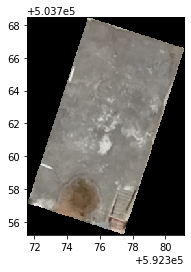

In [15]:
# Open an individual rooftop
with rasterio.open('https://mapping-disaster-risk.s3.amazonaws.com/tst3.tif') as tiff:
    show(tiff)

In [12]:
with rasterio.open('https://mapping-disaster-risk.s3.amazonaws.com/borde_rural_ortho-cog.tif') as tiff:
    print('hi')


RasterioIOError: '/vsicurl/https://mapping-disaster-risk.s3.amazonaws.com/borde_rural_ortho-cog.tif' not recognized as a supported file format.